# Student Alcohol Consumption

WHAT??? 

Prédire les notes des étudiants en fonction de facteurs tels que la consommation d'alcool ? 
PS: peu importe ce qu'on en déduira, pas touche à notre cher... 

On s'intéresse à un jeu de données social où ont été recueillies des informations sur des lycéens à propos de leurs conditions. Les notes qu'ils ont obtenus à leurs examens sont églament présentes. On voudrait pouvoir prédire les notes obtenues en fonction des conditions sociales des étudiants.

Plus infos sur le dataset: https://www.kaggle.com/uciml/student-alcohol-consumption/home

## Chargement des données

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('./student-alcohol-consumption/student-mat.csv')
df.shape

(395, 33)

On a 395 lignes et 33 colonnes. Chaque ligne correspond à un étudiant. Les colonnes sont les variables, elles décrivent les informations à propos de l'étudiant comme son âge, sexe, son temps de transport pour aller à l'école, le temps qu'il travaille à la maison, sa consommation d'alcool, etc. La liste complète de ces variables (les features) et leur explication est disponible ici: https://www.kaggle.com/uciml/student-alcohol-consumption/home

In [2]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

On cherche à prédire quels sont les résultats scolaires des étudiants. Il y a pour chacun 3 notes: G1 (first period grade), G2 (second period grade) et G3 (final grade).

Question, est-ce que la consommation d'alcool influe sur le résultat des élèves ? Réponse !

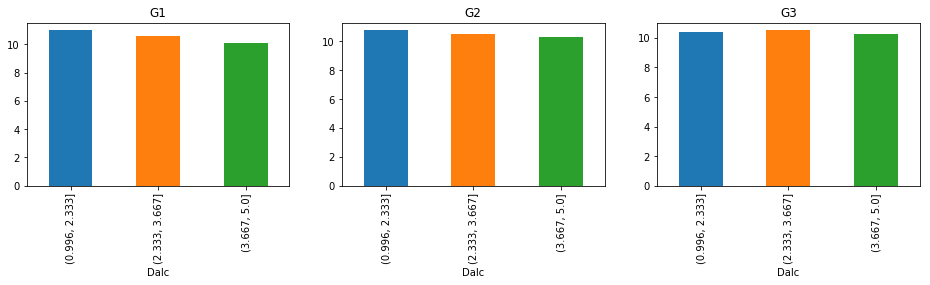

In [3]:
# On affiche pour chaque examen (G1-3) les moyennes des notes selon la catégorie de consommation
# d'alcool en semaine (oui, en semaine). Dalc est la variable correspondante (voir la doc)
fig, axes = plt.subplots(1,3, figsize=(16, 3))
for a in [("G1", axes[0]), ("G2", axes[1]), ("G3", axes[2])]:
    df.groupby(pd.cut(df["Dalc"], 3))[a[0]].mean().plot.bar(ax=a[1], title=a[0])
plt.show()

On se rend compte que NON, ça n'influe pas (presque pas, aller).

## Plus sérieusement

On souhaite toujours prédire la note d'un élève en fonction de toutes les variables à disposition. On choisi de ne garder que la variable G3 pour simplifier le problème. On pourrait aussi faire une moyenne de ces 3 notes. Au choix. G3 sera donc notre variable à prédire (target feature).

In [4]:
data = df.drop(["G1", "G2"], axis=1)
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G3'],
      dtype='object')

In [5]:
data.sample(10)

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
55      GP   F   16       U     GT3       A     2     1     other     other   
155     GP   M   15       R     GT3       T     2     3   at_home  services   
151     GP   M   16       U     LE3       T     2     1   at_home     other   
82      GP   F   15       U     LE3       T     3     2  services     other   
24      GP   F   15       R     GT3       T     2     4  services    health   
18      GP   M   17       U     GT3       T     3     2  services  services   
75      GP   M   15       U     GT3       T     4     3   teacher     other   
150     GP   M   18       U     LE3       T     1     1     other     other   
85      GP   F   15       U     GT3       T     4     4  services  services   
261     GP   M   18       U     GT3       T     4     3   teacher     other   

    ... internet romantic  famrel  freetime  goout Dalc Walc health absences  \
55  ...      yes      yes       5         3      4    1    1      2        8   
155 ...       no       no       4         4      4    1    1      1        2   
151 ...       no      yes       4         4      4    3    5      5        6   
82  ...      yes       no       4         4      4    1    1      5       10   
24  ...      yes       no       4         3      2    1    1      5        2   
18  ...      yes       no       5         5      5    2    4      5       16   
75  ...      yes       no       4         3      3    2    3      5        6   
150 ...      yes      yes       2         3      5    2    5      4        0   
85  ...      yes      yes       4         4      4    2    3      5        6   
261 ...      yes       no       4         3      2    1    1      3        2   

     G3  
55   10  
155   8  
151  14  
82    6  
24    8  
18    5  
75   10  
150   0  
85    8  
261   8  

[10 rows x 31 columns]

## Travailler avec les variables catégorielles

Il y a ce qu'on appelle des variables catégorielles, dont les valeurs ne sont pas numériques et continues. Il y a par exemple la variable `school` qui est soit GP soit MS (nom des deux écoles). Mais aussi `Mjob` (mother's job) qui prend des valeurs dans {teacher, health, services, ...}. Ces valeurs ne sont pas calculables telles quelles. Seuls les arbres de décisions peuvent accepter ces valeurs (pourquoi ?).

Il faut donc faire une transformation. Deux stratégies sont possibles:

* **Integer encoding** : on donne une valeur entière à chaque modalité (teacher devient 0, health devient 1, services 2, etc). Le problème avec ça, c'est qu'on introduit un biais. 0 < 2 et donc _teacher_ deviendrait "inférieur" à _services_ ? Cette stratégie n'est donc pas toujours pertinente, sauf pour les modalités où il y a une relation d'ordre.

* **One-hot encoding**: on va binariser les variables, par exemple `school` va prendre les valeurs 0 et 1. Si school=GP alors on met 0 à place, si school=MS on met 1. Mais qu'est-ce qu'il se passe lorsque notre a variable a plus de deux modalités possibles (`Mjob`) ? Il faut créer des nouvelles variables ! `Mjob_teacher` prend la valeur 0 si ce n'est pas teacher et 1 si oui, `Mjob_health` pareil, etc. En fait, si on a $n$ modalités, on peut créer $n$ variables. En pratique $n-1$, car la dernière modalité correspondrait au cas où les $n-1$ variables crées sont à 0. Un article qui reprend cette méthode: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

Notre dataset contient beaucoup de variables catégorielles, on vous épargne le preprocessing à faire dessus, mais c'est toujours bon d'avoir ça en tête. En pratique, la majorité des datasets ont besoin de passer par là !

In [7]:
final_data = data.copy()
for feature in [
    "school", "sex", "address", "famsize", "Pstatus",
    "Medu", "Fedu", "Mjob", "Fjob", "reason", "guardian",
    "schoolsup", "famsup", "paid", "activities", "nursery",
    "higher", "internet", "romantic"
]:
    final_data = final_data.join(pd.get_dummies(final_data[feature]), lsuffix=f"_{feature}").drop(feature, axis = 1)

final_data.sample(10)

age  traveltime  studytime  failures  famrel  freetime  goout  Dalc  \
108   15           4          4         0       1         3      5     3   
349   18           2          1         1       2         5      5     5   
182   17           1          2         0       5         4      2     2   
384   18           2          1         1       5         4      3     4   
226   17           1          2         0       5         3      4     1   
102   15           1          1         0       5         3      3     1   
93    16           2          2         0       5         3      3     1   
48    15           1          2         0       4         3      3     2   
193   16           1          1         0       4         3      2     3   
377   18           1          2         0       5         4      3     3   

     Walc  health_Mjob ...   no_nursery  yes_nursery  no_higher  yes_higher  \
108     5            1 ...            0            1          0           1   
349     5            5 ...            1            0          1           0   
182     3            5 ...            0            1          0           1   
384     3            3 ...            1            0          0           1   
226     3            3 ...            0            1          1           0   
102     1            5 ...            0            1          1           0   
93      1            1 ...            0            1          0           1   
48      2            5 ...            1            0          0           1   
193     4            5 ...            0            1          0           1   
377     4            2 ...            0            1          0           1   

     no_internet  yes_internet  no_romantic  yes_romantic  no  yes  
108            0             1            0             1   0    1  
349            0             1            0             1   1    0  
182            0             1            1             0   1    0  
384            0             1            1             0   1    0  
226            0             1            0             1   1    0  
102            0             1            0             1   1    0  
93             0             1            0             1   1    0  
48             0             1            1             0   1    0  
193            0             1            0             1   1    0  
377            0             1            0             1   1    0  

[10 rows x 65 columns]

In [8]:
final_data.shape

(395, 65)

On obtient des données uniquement numériques, mais avec beaucoup plus de colonnes.

# A vous de jouer
Visualiser, faire potentiellement une sélection de variables (il y en aurait-il trop par rapport au nombre de samples/lignes?), diviser les données en train/test puis appliquer les modèles vus en cours (et d'autres) pour construire le meilleur régresseur capable de prédire la variable G3. Utiliser Scikit-learn. Bonne chance !

PS: de manière générale, cherchez à visualiser et comprendre les données pour comprendre pourquoi ça marche bien ou pas, ne soyez pas étonné si les résultats ne sont pas bons au début

In [9]:
# Données numpy à utiliser
X = final_data.drop("G3", axis=1).values
y = final_data["G3"].values
X.shape, y.shape

((395, 64), (395,))

In [107]:
# commencer ici